#### Project notes based on other presentations
- Have a conservation check for each run
- show diagram of grid
- insert CFL condition
- grid sensitivity study
- mention the grids and discretizations
- mention bugs or issues you ran into
- mathematical introduction before discretization

#### Notes to self
- Revisit the horizontal momentum equation and the incorporation of velocity
- Try changing the z-value of the upper domain to avoid damping
- Change the time stepping scheme to higher-order

In [848]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('./assets/custom.mplstyle')

#### Grid indexing philosophy

`j` corresponds to the y-axis \
`i` corresponds to the x-axis

#### Grid basis setup

In [849]:
# Define grid point parameters
x_min, x_max = [0, 1]
z_min, z_max = [0, 1]
dx, dz = 0.1, 0.1
# Define base grid basis "vectors" (bv) to outline grid formation (step size added to maximum bound to include it)
bv_base_x = np.arange(x_min, x_max+dx, dx)
bv_base_z = np.arange(z_min, z_max+dz, dz)
# Build base grid meshgrid
base_x, base_z = np.meshgrid(bv_base_x, bv_base_z)

# CFL number
cfl = 0.1
# Timestep (assume c = 1)
dt = cfl*dx

#### Grid plotting

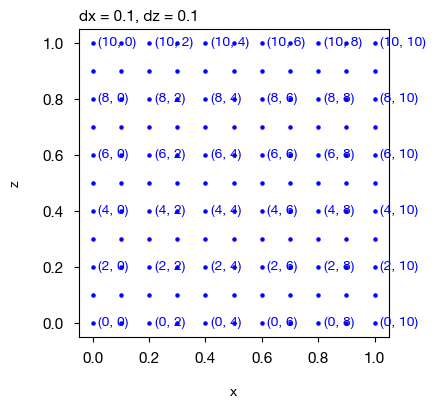

In [850]:
fig, ax = plt.subplots(figsize=(4, 4))
im_base = ax.scatter(base_x, base_z, s=5)

point_labels = True

# Annotate grid points for troubleshooting
if point_labels == True:
    # Choose type of annotation for point labels [index = (i, j) space, absolute = (x, y) space]
    point_label_type = 'index' # choose 'index' or 'absolute'
    point_label_skip = 2 # print grid point label every N points
    for j, z in enumerate(base_z):
        for i, x in enumerate(base_x):
            point_label = '({0}, {1})'.format(j, i) if point_label_type == 'index' else '({0:.1f}, {1:.1f})'.format(x[i], z[j])
            if j % point_label_skip == 0 and i % point_label_skip == 0:
                ax.annotate(point_label, (x[i], z[j]), xytext=(x[i] + 0.02, z[j] - 0.01), fontsize=10, c='b')

# Axis title
ax_title_str = 'dx = {0}, dz = {1}'.format(dx, dz)
ax.set_title(label=ax_title_str)
ax.set_xlabel('x')
ax.set_ylabel('z')

plt.show()

#### Second-pass discretization
__Spatial__: 2nd-order centered difference, B-grid (u, w on the 1/2 points, $\rho$ on the integer points) \
__Temporal__: AB2 to start, AB3 to continue

__Function:__ $\partial \rho / \partial t$

In [881]:
def disc(fields, refs, dx, dz, dt, t, printout=False):
    
    # Load reference values
    rho_0, p_0 = refs
    # Load current values (n)
    x, z, rho, p, u, w = fields
    
    for j in range(0, len(z)):
        for i in range(0, len(x)):
            
            # p_0[0, i] = 0 # Try setting reference pressure p_0 to ground pressure
            
            # Create modulo-based indices for lateral doubly-periodic conditions
            l, r = (i-1) % len(x), (i+1) % len(x) # left (l) and right (r)
            
            ''' Define derivatives. '''
            # Handle horizontal differentiation
            du_dx = (u[j, r, t] - u[j, l, t])/(2*dx)
            dw_dx = (w[j, r, t] - w[j, l, t])/(2*dx)
            drho_dx = (rho[j, r, t] - rho[j, l, t])/(2*dx)
            dp_dx = (p[j, r, t] - p[j, l, t])/(2*dx)
            dp_0_dx = (p_0[j, r] - p_0[j, l])/(2*dx)
            
            # Handle bottom boundary (2nd-order forward FD)
            if j == 0:
                du_dz = (-3*u[j, i, t] + 4*u[j+1, i, t] - u[j+2, i, t])/(2*dz)
                dw_dz = (-3*w[j, i, t] + 4*w[j+1, i, t] - w[j+2, i, t])/(2*dz)
                drho_dz = (-3*rho[j, i, t] + 4*rho[j+1, i, t] - rho[j+2, i, t])/(2*dz)
                dp_dz = (-3*p[j, i, t] + 4*p[j+1, i, t] - p[j+2, i, t])/(2*dz)
                dp_0_dz = (-3*p_0[j, i] + 4*p_0[j+1, i] - p_0[j+2, i])/(2*dz)
            
            # Handle top boundary (2nd-order backward FD)
            elif j == (len(z) - 1):
                du_dz = (3*u[j, i, t] - 4*u[j-1, i, t] + u[j-2, i, t])/(2*dz)
                dw_dz = (3*w[j, i, t] - 4*w[j-1, i, t] + w[j-2, i, t])/(2*dz)
                drho_dz = (3*rho[j, i, t] - 4*rho[j-1, i, t] + rho[j-2, i, t])/(2*dz)
                dp_dz = (3*p[j, i, t] - 4*p[j-1, i, t] + p[j-2, i, t])/(2*dz)
                dp_0_dz = (3*p_0[j, i] - 4*p_0[j-1, i] + p_0[j-2, i])/(2*dz)
            
            # Rest of grid
            else:
                du_dz = (u[j+1, i, t] - u[j-1, i, t])/(2*dz)
                dw_dz = (w[j+1, i, t] - w[j-1, i, t])/(2*dz)
                drho_dz = (rho[j+1, i, t] - rho[j-1, i, t])/(2*dz)
                dp_dz = (p[j+1, i, t] - p[j-1, i, t])/(2*dz)
                dp_0_dz = (p_0[j+1, i] - p_0[j-1, i])/(2*dz)
            
            ''' Governing equations. '''
            # Buoyancy material evolution
            rho[j, i, t+1] = rho[j, i, t] + dt*(-u[j, i, t]*drho_dx - w[j, i, t]*drho_dz)
            # Horizontal velocity - suppressed until hydrostatic balance is resolved
            u[j, i, t+1] = u[j, i, t] + dt*(-u[j, i, t]*du_dx - w[j, i, t]*du_dz - (1/rho_0)*dp_dx + (1/rho_0)*dp_0_dx)
            # Vertical velocity
            w[j, i, t+1] = w[j, i, t] + dt*(-u[j, i, t]*dw_dx - w[j, i, t]*dw_dz - (1/rho_0)*dp_dz + (1/rho_0)*dp_0_dz - g*(rho[j, i, t]-rho_0)/rho_0)
            # Pressure evolution
            p[j, i, t+1] = -g*rho[j, i, t]*z[j, i]
            # Continuity - this is a 'diagnostic'
            # cont = du_dx + dw_dz
            
            ''' Print statements (once per row, every n rows, for brevity). '''
            n = 5
            if i == len(x) // 2 and j % n == 0 and printout == True:
                print('({0}, {1})'.format(j, i))
            
                print('\t Density: {0:.2e}'.format(rho[j, i]))
                ### Density
                # if j == 0:
                #     print('\t drho/dz: {0:.2e}, self: {1:.2e}, z+1: {2:.2e}, z+2: {3:.2e}'.format(drho_dz, -3*rho[j, i], 4*rho[j+1, i], -rho[j+2, i]))
                # elif j == len(z)-1:
                #     print('\t drho/dz: {0:.2e}, self: {1:.2e}, z-1: {2:.2e}, z-2: {3:.2e}'.format(drho_dz, 3*rho[j, i], -4*rho[j-1, i], rho[j-2, i]))
                # else:
                #     print('\t drho/dz: {0:.2e}, z+1: {1:.2e}, z-1: {2:.2e}'.format(drho_dz, rho[j+1, i], rho[j-1, i]))
                ### Vertical gradient of pressure
                # if j == 0:
                #     print('\t dp/dz: {0:.2e}, self: {1:.2e}, z+1: {2:.2e}, z+2: {3:.2e}'.format(dp_dz, p[j, i], p[j+1, i], p[j+2, i], 2*dz))
                # elif j == len(z)-1:
                #     print('\t dp/dz: {0:.2e}, self: {1:.2e}, z-1: {2:.2e}, z-2: {3:.2e}'.format(dp_dz, p[j, i], p[j-1, i], p[j-2, i], 2*dz))
                # else:
                #     print('\t dp/dz: {0:.2e}, z+1: {1:.2e}, z-1: {2:.2e}'.format(dp_dz, p[j+1, i], p[j-1, i], 2*dz))
                ### Vertical velocity
                # print('\t w_n: {0:.2e}, w: {1:.2e}, u(dw/dx): {2:.2e}, w(dw/dz): {3:.2e}, rho^-1 dp/dz: {4:.2e}, rho^-1 dp0/dz: {5:.2e}, b: {6:.2e}'.format(w_n[j, i], w[j, i], -u[j, i]*dw_dx, -w[j, i]*dw_dz, -(1/rho_0)*dp_dz, (1/rho_0)*dp_0_dz, -g*(rho[j, i]-rho_0)/rho_0))
                ### Pressure
                # print('\t p_n: {0:4.2f} | -g*rho*z: {1:4.2f} | p_0: {2:4.2f}'.format(p_n[j, i], -g*rho[j, i]*z[j, i], p_0[j, i]))
                ### Continuity
                # print('\t Continuity at ({0}, {1}): {2:.3f}'.format(j, i, cont))
                ## Check hydrostatic balance per Griffies (2022), Eqn. 25.25b
                # print('\t Hydrostatic balance: {0:.2e}'.format(-(1/rho_0)*dp_dz + (1/rho_0)*dp_0_dz - g*(rho[j, i]-rho_0)/rho_0))

    return rho, p, u, w

#### Initialize grids

In [885]:
# Number of timesteps
n_steps = 10
# Time domain
times = np.arange(0, dt*n_steps, dt)

g = 1
p_0 = 0
rho_0 = 1
u_0, w_0 = 0, 0

rho_init = np.full(shape=(len(base_z), len(base_x), len(times)), fill_value=rho_0, dtype=float)
center_x = len(base_x) // 2
rad = 2
mag = -0.5
rho_init[0:2, ((center_x-rad)+1):(center_x+rad)] = rho_0 + mag

rho = {'name': '$\\rho$',
       'long_name': 'Density',
       'units': r'kg m$^{-3}$',
       'values': np.full(shape=(len(base_z), len(base_x), len(times)), fill_value=rho_init, dtype=float)}

u = {'name': '$u$',
          'long_name': 'Velocity, horizontal',
          'units': r'm s$^{-1}$',
          'values': np.full(shape=(len(base_z), len(base_x), len(times)), fill_value=u_0, dtype=float)}

w = {'name': '$w$',
          'long_name': 'Velocity, vertical',
          'units': r'm s$^{-1}$',
          'values': np.full(shape=(len(base_z), len(base_x), len(times)), fill_value=w_0, dtype=float)}

p = {'name': '$p$',
       'long_name': 'Pressure',
       'units': r'Pa',
       'values': np.full(shape=(len(base_z), len(base_x), len(times)), fill_value=p_0, dtype=float)}

# Initialize pressure field
p_0 = -rho['values'][:, :, 0]*g*base_z + p_0
# Initialize backgorund pressure state
p['values'][:, :, 0] = p_0
# Initialize list of reference values
refs = [rho_0, p_0]
printout = False

for step in range(0, len(times)-1):
    if printout:
        print('---------------------------')
        print('Time: {0:.3f} s'.format(times[step]))
    fields = [base_x, base_z, rho['values'], p['values'], u['values'], w['values']]
    rho['values'], p['values'], u['values'], w['values'] = disc(fields, refs, dx, dz, dt, step)

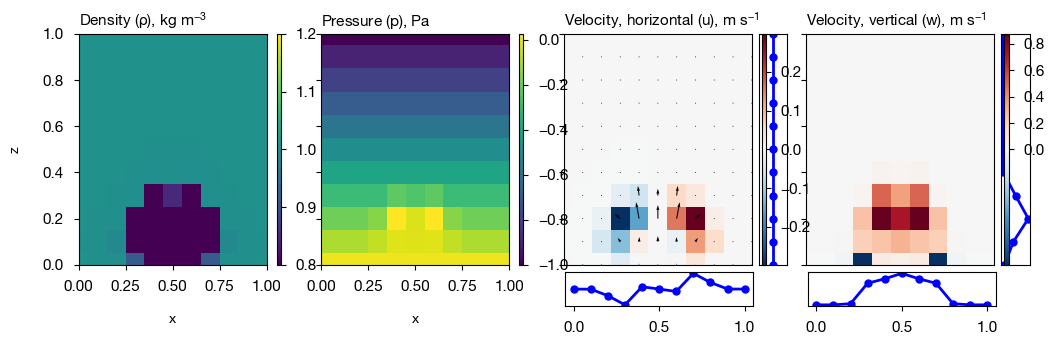

In [884]:
field_plot([base_x, base_z], [rho, p, u, w], 145)

#### Field plots

##### Multi-plot

In [855]:
from matplotlib import animation
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable as ml
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Reset rcParams
plt.rcParams.update(plt.rcParamsDefault)
plt.gca()
plt.style.use('./assets/custom.mplstyle')

def field_plot(grids, datasets, timestep=0):

    x, z = grids
    
    nrows, ncols = 1, len(datasets)
    fig, axs = plt.subplots(figsize=(3*ncols, 3*nrows), ncols=ncols, sharey=True)

    for i, data in enumerate(datasets):
        ax = axs[i]
        values = data['values'][:, :, timestep]

        # Set bounds for values
        if data['long_name'] == 'Density':
            vmin, vmax = [0.8, 1.2]
        else:
            vmin, vmax = [None, None]
            
        # Set colormaps
        if 'Velocity' in data['long_name']:
            try:
                norm = matplotlib.colors.TwoSlopeNorm(vmin=values.min(), vcenter=0, vmax=values.max())
                cmap = 'RdBu_r'
            except:
                if values.max() > 0:
                    norm = matplotlib.colors.TwoSlopeNorm(vmin=-0.01, vcenter=0, vmax=values.max())
                else:
                    norm = matplotlib.colors.TwoSlopeNorm(vmin=-0.01, vcenter=0, vmax=0.01)
                cmap = 'RdBu_r'
                # norm = None
        else:
            cmap = 'viridis'
            norm = None
        
        im = ax.pcolormesh(x, z, values, vmin=vmin, vmax=vmax, norm=norm, cmap=cmap)
        # im = ax.contourf(x, z, values, vmin=vmin, vmax=vmax, norm=norm, cmap=cmap, levels=24)
        
        # Create quiver plots for velocity
        if data['long_name'] == 'Velocity, horizontal':
            ax.quiver(x, z, datasets[-2]['values'][:, :, timestep], datasets[-1]['values'][:, :, timestep], scale=10)
        
        # Create velocity insets for cross-sectional velocity profiles
        inset_size = '15%'
        if 'Velocity' in data['long_name']:
            # Vertical insets for velocity profile slice
            slice_v = inset_axes(ax, height='100%', width=inset_size, loc='center left', bbox_to_anchor=(1, 0, 1, 1), bbox_transform=ax.transAxes)
            slice_v_idx = len(x) // 2 # horizontal center of domain
            slice_profile_v = slice_v.plot(values[:, slice_v_idx], z[:, slice_v_idx], marker='o')
            slice_v.set_xticks([])
            slice_v.set_yticks([])
            slice_v.set_ylim(ax.get_ylim())
            
            # Horizontal inset for velocity profile
            slice_h = inset_axes(ax, height=inset_size, width='100%', loc='upper left', bbox_to_anchor=(-0.03, -1, 1, 1), bbox_transform=ax.transAxes)
            slice_h_idx = 1
            slice_profile_h = slice_h.plot(x[slice_h_idx, :], values[slice_h_idx, :], marker='o')
            ax.set_xticks([])
            slice_h.set_yticks([])
    
        # Axis properties
        ax.set_xlim([x.min(), x.max()])
        ax.set_ylim([z.min(), z.max()])
        # Axis title
        ax.set_xlabel('x')
        ax.set_ylabel('z') if i == 0 else None

        # Colorbar
        cax_width = 0.25*ax.get_position().width
        divider = ml(ax)
        cax = divider.append_axes('right', size=cax_width, pad=0.1)
        cb = fig.colorbar(im, cax=cax)
        

        # Metadata
        ax_title_str = r'{0} ({1}), {2}'.format(data['long_name'], data['name'], data['units'])
        ax.set_title(label=ax_title_str)
        
    # fig.tight_layout()
    plt.show()

##### Animation

In [880]:
from matplotlib import animation
import matplotlib.pyplot as plt_
plt_.rcParams["animation.html"] = "jshtml"
plt_.ioff()
plt_.cla()
   
grids = [base_x, base_z]

fig, ax = plt.subplots(figsize=(3, 3))
    
# Animation function
def animate(i):
    
    ax.cla()
    
    x, z = grids

    q = ax.quiver(x, z, u['values'][:, :, i], w['values'][:, :, i], scale=1)

    # Axis properties
    ax.set_xlim([x.min(), x.max()])
    ax.set_ylim([z.min(), z.max()])
    # Axis title
    ax.set_xlabel('x')
    ax.set_ylabel('z') if i == 0 else None

    # Metadata
    ax_title_str = r'Time: {0:.2f} s'.format(times[i])
    ax.set_title(label=ax_title_str)

# Animation generation and save settings
animation.FuncAnimation(fig, animate, frames=u['values'].shape[2], interval=25)
# anim = animation.FuncAnimation(fig, animate, frames=10, interval=intv)
# anim.save('figs/animation_20221108-success-dx_0.02.gif', dpi=300)